# **【AI达人创造营第二期】作业四：头颈部咽喉癌病灶分割**


# 一、项目背景介绍
喉癌和下咽癌是常见的头颈部恶性肿瘤，不仅会导致患者的发音、呼吸和吞咽功能失常，还会严重威胁患者生命。增强 CT 成像是临床评估喉癌和下咽癌的重要手段。然而，头颈癌被认为是放射肿瘤学领域中轮廓绘制最困难和最耗时的疾病部位之一。这项任务通常是人工完成的，是一项耗时且劳动密集型的任务。另一方面，最终的诊断结果容易受到不同医师之间的主观因素影响而存在差异。

近年来，虽然喉癌和下咽癌自动化分割算法的研究有了很大的发展，但仍面临一些有待解决的问题。因此，研究一种准确、实用的喉癌和下咽癌分割算法对于治疗方案的制定和放疗总成本的降低有重要意义。

本此项目使用UNet模型对3D增强CT图像进行窗宽窗位校正处理，再转存为2D图像后对其进行病灶分割，并使用PyQt5制作的[图形化小工具](https://aistudio.baidu.com/aistudio/projectdetail/2574999)进行本地部署。

# 二、数据介绍

此次选择的是2021 年（第14 届）中国大学生计算机设计大赛-人工智能应用-人工智能挑战赛-医学影像挑战赛提供的国赛数据集。该数据集为头颈部三维增强CT影像，所有数据均为 NiFTI 格式三维图像，不同患者使用数字格式编号。拥有90个头颈部三位增强CT影像与90个同等格式的标注数据

![](https://ai-studio-static-online.cdn.bcebos.com/b352df19314b42f78887ea949d050596f581cc4f4f724a3384b2066ad05882fe)


* 噪声多，病灶与正常组织对比度不高且边界模糊。所有病人的CT影像维度在XY轴方向上均为512×512，在Z轴方向上处于41-130之间。CT像素间距在XY轴方向上处于0.455mm-0.977mm之间，在Z轴方向上为3mm或5mm。CT值范围处于-1024.0-3071.0之间，噪声区域较多。

![](https://ai-studio-static-online.cdn.bcebos.com/fb1a712865244efd8c7e0b1fef7df350087b3e886fd14225a23dcd92a4b13bd7)


* 各病灶中心点不同

![](https://ai-studio-static-online.cdn.bcebos.com/e9c968a9c87f47d4b191bb92bef11bda00d44b79235b416b9d677a8214a94542)


* 正负样本比例失衡。病灶的总体积以及包含病灶的切片较少，90例数据总共7000+的切片，只有1000左右的切片包含病灶，病灶面积远远少于正常组织和整张图像面积。

![](https://ai-studio-static-online.cdn.bcebos.com/ee0cf7a51be4476d970d172defec597e275c20ab0b464444b0dbec1580c14ae7)






# **总体方案**

## 数据预处理
* 对3D增强CT图像进行窗宽窗位的校正并缩放了0到255，减少噪声；

* 该数据集的数据每个nii文件的图像横断面只有48~130张切片，与肝脏CT数据平均几百张切片相比，该数据更适合采用2D分割，所以需要将3D 图像转存为2D图像；

* 在转存为2D图像之前根据label数据和灰度值将nii图像进行阶段，否则负样本比例太高可能影响模型收敛；

* 预留出十个左右的样本作为测试集，预测之后根据3D Dice系数判断模型的优化程度。

## 模型搭建
* 使用水平反转、高斯噪声等数据增强策略进行数据扩充。因为病灶面积太小，使用缩放的时候尽量放大。
* 采用余弦退火学习率下降策略并配合AdamW进行训练能够较快地收敛。

## 图形化预测小工具使用
这个就得去看[吖查小哥哥](https://aistudio.baidu.com/aistudio/personalcenter/thirdview/181096)的[项目](https://aistudio.baidu.com/aistudio/projectdetail/2574999)啦，我就不多做解释了。







## 一，安装相关的依赖库

In [ ]:
#安装 nii处理工具  SimpleITK 和分割工具paddleSeg
!pip install SimpleITK #专门处理医学格式nii文件
!pip install paddleseg
!pip install nibabel
!pip install imageio 
!pip install nilearn

In [ ]:
%cd /home/aistudio/
#首次要运行
!unzip -oq /home/aistudio/data/data97507/traindata.zip -d work/

In [ ]:
#导入常用库
import os
import cv2
import time
import paddle
import random
import numpy as np
from tqdm import tqdm
import nibabel as nib
import SimpleITK as sitk
from random import shuffle
import matplotlib.pyplot as plt


# 二、数据预处理


## 2.1 窗宽窗位调整
采用了观察软组织的窗位窗位最佳参数

### 使用不同窗宽窗位进行观察

(512, 512, 95)


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow w

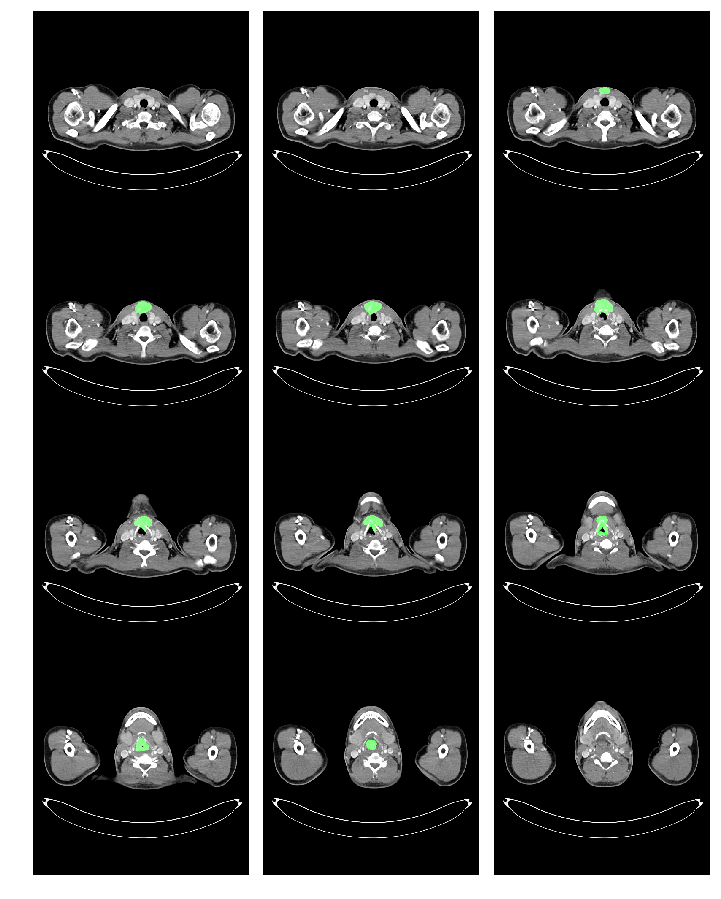

In [5]:
def wwwc(sitkImage,ww,wc):
    #设置窗宽窗位
    min = int(wc - ww/2.0)
    max = int(wc + ww/2.0)
    intensityWindow = sitk.IntensityWindowingImageFilter()
    intensityWindow.SetWindowMaximum(max)
    intensityWindow.SetWindowMinimum(min)
    sitkImage = intensityWindow.Execute(sitkImage)
    return sitkImage

origin = sitk.ReadImage('/home/aistudio/work/traindata/data/001.nii')
print(origin.GetSize())
mask = sitk.ReadImage('/home/aistudio/work/traindata/label/001.nii')
origin = wwwc(origin, 350, 50) # 设置窗宽窗位参数
mask= sitk.Cast(mask, sitk.sitkUInt8)
#原图和mask叠加在一起
new_data= sitk.LabelOverlay(origin, mask, opacity=0.01)
data = sitk.GetArrayFromImage(new_data)
d = data.shape[0]

plt.figure(figsize=(12,12))
for index,i in enumerate(range(int(d*0.6)+2,int(d*0.6)+14)) :
    plt.subplot(4,3,index+1)
    plt.imshow(data[i,...])
    plt.axis('off')
    plt.subplots_adjust(left=0.0,bottom=0.0,top=1,right=0.8,wspace =0.0001, hspace =0.0001)#调整子图间距
plt.show()

### 窗宽窗位校正

![](https://ai-studio-static-online.cdn.bcebos.com/2cca0eb9615e45fbb63a0e1fc7b42288fd18482905ab493f8da81e73d2b5cf17)


In [6]:
#导入常用的库
import time
from tqdm import tqdm
import SimpleITK as sitk

ww = 350
wc = 50

new_path = "work/traindata"
new = "work/new"
def winWid_cen(src_path,ww,wc,file_name):
    #设置窗宽窗位
    min = int(wc - ww/2.0)
    max = int(wc + ww/2.0)
    intensityWindow = sitk.IntensityWindowingImageFilter()
    intensityWindow.SetWindowMaximum(max)
    intensityWindow.SetWindowMinimum(min)

    sitkImage = sitk.ReadImage(src_path)
    sitkImage = intensityWindow.Execute(sitkImage)
    sitk.WriteImage(sitkImage,file_name)
    return sitkImage

def readNii(src_path,file_name):
    sitkImage = sitk.ReadImage(src_path)
    sitk.WriteImage(sitkImage,file_name)
    return sitkImage

if __name__=='__main__':
    for file_id in tqdm(range(1, 81)):
        src_path = r'work/traindata/data/%03d.nii' % file_id
        file_name = '%03d.nii' % file_id
        winWid_cen(src_path,ww,wc, new_path+"/data/"+file_name)
        time.sleep(0.00001)

100%|██████████| 80/80 [00:56<00:00,  1.43it/s]


## 2.2 图像截断
根据标注数据和灰度值阈值进行截断，去掉一些多余切片

再次之前肯定得进行窗宽窗位的校正并且缩放到0-255，否则图像将是黑抹哒区的一片（当初进行归一化的图像分割出来的结果比没有进行归一化的图像分数更低，这就挺魔性的）

![](https://ai-studio-static-online.cdn.bcebos.com/6c3a4d32a8c146d1b7efb5502097e88c1b069b95c44e4055bbd4fb5c03a8b388)


In [ ]:
raw_dataset_path = '/home/aistudio/work/traindata'
# 预处理后的数据集的输出路径
fixed_dataset_path = '/home/aistudio/work/new_traindata'
if not os.path.exists(fixed_dataset_path):
    os.mkdir(fixed_dataset_path)
if os.path.exists(fixed_dataset_path):    # 创建保存目录
    os.makedirs(os.path.join(fixed_dataset_path,'data'))
    os.makedirs(os.path.join(fixed_dataset_path,'label'))

#喉部的窗宽窗位的范围，
#350
upper = 350
#50
lower = 50
for ct_file in os.listdir(os.path.join(raw_dataset_path ,'data')):
    #读取origin
    ct = sitk.ReadImage(os.path.join(os.path.join(raw_dataset_path ,'data'), ct_file), sitk.sitkInt16)
    #转换成 numpy格式
    ct_array = sitk.GetArrayFromImage(ct)
    seg = sitk.ReadImage(os.path.join(os.path.join(raw_dataset_path ,'label'), ct_file),
                            sitk.sitkInt8)
    seg_array = sitk.GetArrayFromImage(seg)
    print("裁剪前:{}".format(ct.GetSize(), seg.GetSize()))
    

    # 将灰度值在阈值之外的截断掉
    ct_array[ct_array > upper] = upper
    ct_array[ct_array < lower] = lower

    # 找到喉部区域开始和结束的slice
    z = np.any(seg_array, axis=(1, 2))
    start_slice, end_slice = np.where(z)[0][[0, -1]]

    ct_array = ct_array[start_slice - 2:end_slice + 3, :, :]
    seg_array = seg_array[start_slice - 2:end_slice + 3, :, :]

    new_ct = sitk.GetImageFromArray(ct_array)
    new_ct.SetDirection(ct.GetDirection())
    new_ct.SetOrigin(ct.GetOrigin())

    new_seg = sitk.GetImageFromArray(seg_array)
    new_seg.SetDirection(ct.GetDirection())
    new_seg.SetOrigin(ct.GetOrigin())
    print("裁剪后:{}".format(new_ct.GetSize(), new_seg.GetSize()))

    sitk.WriteImage(new_ct, os.path.join(os.path.join(fixed_dataset_path ,'data'), ct_file))
    sitk.WriteImage(new_seg,
                    os.path.join(os.path.join(fixed_dataset_path , 'label'), ct_file))



## 2.3 将截断后的3D 数据根据Z轴切割转存为2D图像

![](https://ai-studio-static-online.cdn.bcebos.com/f4143047517d4f62b1bf5f150703e13b4296fd03430d41af8fc2d4284520dcc8)




In [9]:
data_path = 'work/new_traindata/data'
label_path = 'work/new_traindata/label'
count = 0
if not os.path.exists('/home/aistudio/work/newdata'):
    os.mkdir('/home/aistudio/work/newdata')
    os.makedirs(os.path.join('/home/aistudio/work/newdata','origin'))
    os.makedirs(os.path.join('/home/aistudio/work/newdata','label'))
index_dict = {81,82,83,84,85,86,87,88,89,90}
for f in tqdm(os.listdir(data_path)):
    fname = int(f.split(".")[0])
    # 排除后10个样本
    if fname in index_dict: 
        continue
    origin_path= os.path.join(data_path, f)
    seg_path = os.path.join(label_path,f)
    origin_array = sitk.GetArrayFromImage(sitk.ReadImage(origin_path))
    seg_array = sitk.GetArrayFromImage(sitk.ReadImage(seg_path))
    for i in range(seg_array.shape[0]):
        seg_image = seg_array[i,:,:]
        seg_image = np.rot90(np.transpose(seg_image, (1,0)))
        origin_image = origin_array[i,:,:]
        origin_image = np.rot90(np.transpose(origin_image, (1,0)))
        cv2.imwrite('work/newdata/label/'+str(count) + '.png', seg_image)
        cv2.imwrite('work/newdata/origin/'+str(count) + '.jpg', origin_image)
        count += 1
    time.sleep(0.00001)
#打印转换后的数据量
print(count)

100%|██████████| 90/90 [00:08<00:00, 10.49it/s]

897


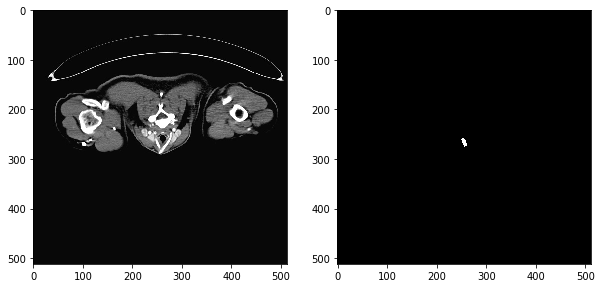

In [15]:
#显示某一层喉部图片
image = cv2.imread('work/newdata/origin/50.jpg',0)
label = cv2.imread('work/newdata/label/50.png',0)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(image,'gray')

plt.subplot(122)
plt.imshow(label*255, 'gray')
plt.show()

# 三、划分数据集 

In [16]:
random.seed(2022)
path_origin = '/home/aistudio/work/newdata/origin'
path_label = '/home/aistudio/work/newdata/label'
files = list(filter(lambda x: x.endswith('.jpg'), os.listdir(path_origin)))
random.shuffle(files)
rate = int(len(files) * 0.8)#训练集和测试集8：2
train_txt = open('/home/aistudio/work/newdata/train_list.txt','w')
val_txt = open('/home/aistudio/work/newdata/val_list.txt','w')
for i,f in enumerate(files):
    image_path = os.path.join(path_origin, f)
    label_name = f.split('.')[0]+ '.png'
    label_path = os.path.join(path_label, label_name)
    if i < rate:
        train_txt.write(image_path + ' ' + label_path+ '\n')
    else:
        val_txt.write(image_path + ' ' + label_path+ '\n')

train_txt.close()
val_txt.close()
print('完成')

完成


# 四、创建DataSet

In [17]:
import paddleseg.transforms as T
from paddleseg.datasets import Dataset

train_transforms = [
    T.RandomHorizontalFlip(),#水平翻转
    T.RandomDistort(),#随机对比度，颜色等变化
    T.RandomRotation(max_rotation = 15,im_padding_value =(0,0,0),label_padding_value = 0),#随机旋转
    T.RandomBlur(),#随机模糊
    T.RandomScaleAspect(min_scale = 0.8, aspect_ratio = 0.5),#随机缩放
    T.Resize(target_size=(512, 512)),
    T.Normalize()#mean Default: [0.5, 0.5, 0.5]  std Default: [0.5, 0.5, 0.5].
]
val_transforms = [
    T.Resize(target_size=(512, 512)),
    T.Normalize()
]

dataset_root = '/home/aistudio/work/newdata'
train_path  = '/home/aistudio/work/newdata/train_list.txt'
val_path  = '/home/aistudio/work/newdata/val_list.txt'
test_path  = '/home/aistudio/work/newdata/test_list.txt'
# 构建训练集
train_dataset = Dataset(
    transforms = train_transforms,
                  dataset_root = dataset_root,
                  num_classes = 2,
                  train_path  = train_path,
                  mode = 'train'
                  )
#验证集
val_dataset = Dataset(
    transforms = val_transforms,
                  dataset_root = dataset_root,
                  num_classes = 2,
                  val_path = val_path,
                  mode = 'val'
                  )



/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


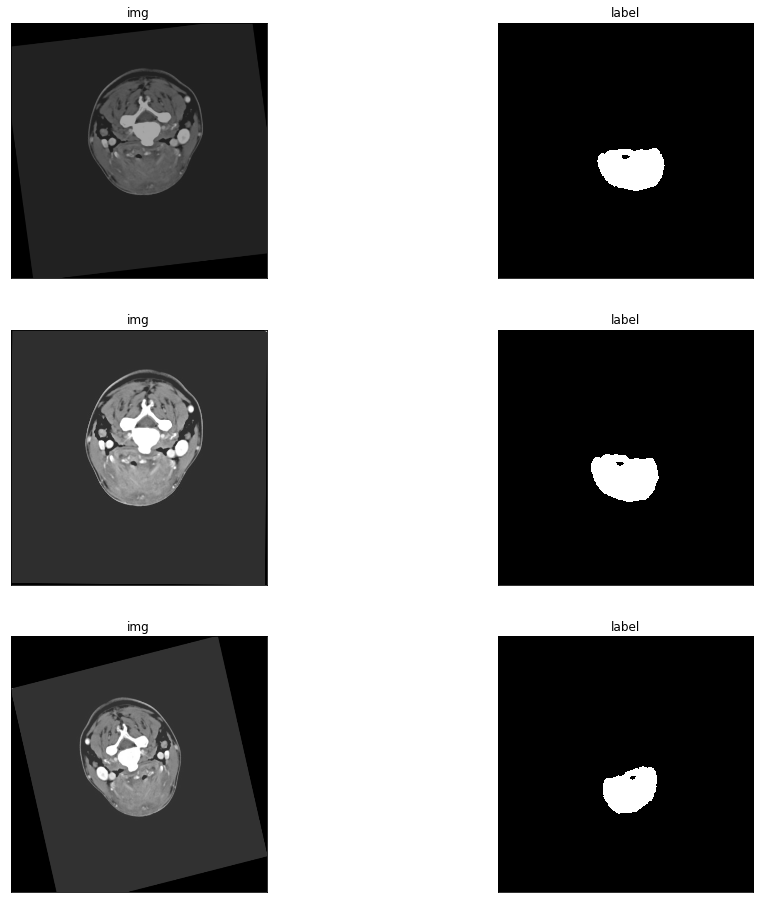

In [18]:
#预览经过数据增强后的数据
#没有显示 ，在运行一次
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(16,16))
for i in range(1,6,2):
    img, label = train_dataset[131]
    img = np.transpose(img, (1,2,0))
    img = img*0.5 + 0.5
    plt.subplot(3,2,i),plt.imshow(img,'gray'),plt.title('img'),plt.xticks([]),plt.yticks([])
    plt.subplot(3,2,i+1),plt.imshow(label*255,'gray'),plt.title('label'),plt.xticks([]),plt.yticks([])
    plt.show

# 五、模型搭建与训练
* 使用的UNet网络，预训练模型是肝脏肿瘤分割的模型，那是三分类模型，可以参考深圳大学的大佬先用相同的参数对其他医学影像数据进行训练，然后再此项目作为预训练模型

    lr_schedule：学习率调得很小，配合学习率下降策略更容易收敛
    
    optimize：之前我习惯用Adam的，但是Adam貌似存在L2正则化失效的问题，所以就改用AdamW了。我还因为使用Adam再一次比赛中被一个榜一大佬点了一次（咳咳，内容就不说了）
    
    epoch：epoch到达80就到了一个峰值，到达100个epoch得时候mIou其实还在上升，如果有时间可以增多epoch
    
    batch_size：一般按照1 2 4 8 16 32 64 来设置
    
    Loss function：这个数据不能使用多分类交叉熵CrossEntropyLoss，单独使用Dice Loss不够稳定，所以就是用了BCE + Dice


In [ ]:
import paddle
from paddleseg.models import UNet,AttentionUNet
from paddleseg.models.losses import DiceLoss,BCELoss,MixedLoss,CrossEntropyLoss

base_lr = 0.000125
# base_lr = 0.0000125
# 设置学习率  
batch_size=16
log_iters = int(len(train_dataset)/batch_size /3) #日志打印间隔
iters = int(len(train_dataset)/batch_size) * 100 #训练次数
save_interval = int(len(train_dataset)/batch_size) * 5 #保存的间隔次数


# model = UNet(num_classes=2)
model = UNet(num_classes=2,pretrained='work/model.pdparams')

#自动调整学习率
lr =paddle.optimizer.lr.CosineAnnealingDecay(base_lr, T_max =(iters // 3), verbose=False)
optimizer = paddle.optimizer.AdamW(lr, parameters=model.parameters())

mixtureLosses = [BCELoss(),DiceLoss()]
mixtureCoef = [0.8,0.2]
losses = {}
losses['types'] = [MixedLoss(mixtureLosses,mixtureCoef)]

losses['coef'] = [1]

In [ ]:
from paddleseg.core import train

train(
    model=model,
    train_dataset=train_dataset,#填写训练集的dataset
    val_dataset=val_dataset,#填写验证集的dataset
    optimizer=optimizer,#优化器
    save_dir='/home/aistudio/output/demo1',#保存路径
    iters=iters,#训练次数
    batch_size=batch_size,
    save_interval=save_interval,#保存的间隔次数
    log_iters=log_iters,#日志打印间隔
    num_workers=0,
    losses=losses,#传入 loss函数
    use_vdl=True)#是否使用visualDL


在验证集上mIou效果还不错

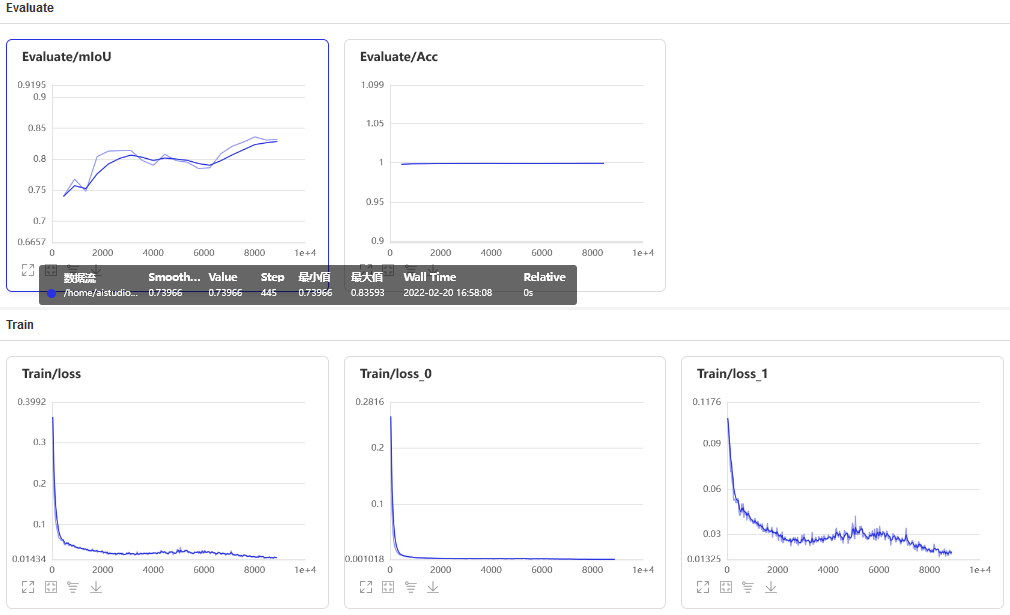

# 六、模型验证
直接使用验证集进行mIou验证

In [ ]:
import paddle
from paddleseg.core import evaluate
#
model = UNet(num_classes=2)

model_path = 'output/demo1/best_model/model.pdparams'
para_state_dict = paddle.load(model_path)
model.set_dict(para_state_dict)
evaluate(model,val_dataset)

# 七、测试集分割
这处批量测试和还原直接抄了[驾长风](https://aistudio.baidu.com/aistudio/personalcenter/thirdview/725102)大佬的脚本，因为懒且菜

In [21]:
#批量读取原始Nii，到模型预测，再把结果保存nii格式
from paddleseg.models import UNet
import cv2
import os
import paddleseg.transforms as T
import paddle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


transforms = T.Compose([
    T.Resize(target_size=(512, 512)),
    T.Normalize()#mean Default: [0.5, 0.5, 0.5]  std Default: [0.5, 0.5, 0.5].
])

def read_intensity(path):
    #设置窗宽窗位
    ww = 350
    wc = 50
    min = int(wc - ww/2.0)
    max = int(wc + ww/2.0)
    sitkImage = sitk.ReadImage(path)
    intensityWindowingFilter = sitk.IntensityWindowingImageFilter()
    intensityWindowingFilter.SetOutputMaximum(255)
    intensityWindowingFilter.SetOutputMinimum(0)
    if 'mask' not in path:
        intensityWindowingFilter.SetWindowMaximum(max)
        intensityWindowingFilter.SetWindowMinimum(min)
    sitkImage = intensityWindowingFilter.Execute(sitkImage)
    return sitkImage


def cnt_area(cnt):
    area = cv2.contourArea(cnt)
    return area


#加载模型
model = UNet(num_classes=2)
model_path = 'output/demo8/best_model/model.pdparams'
para_state_dict = paddle.load(model_path)
model.set_dict(para_state_dict)
model.eval()

path = "work/traindata/data/"   #图像读取地址
savepath = "output_image/"  # 图像保存地址
if not os.path.exists(savepath):
    os.mkdir(savepath)

filelist = os.listdir(path)  # 打开对应的文件夹
total_num = len(filelist)  #得到文件夹中图像的个数


# 后十个样本
index_dict = {81,82,83,84,85,86,87,88,89,90}
l = 80
for f in tqdm(range(total_num)):
    if str(l + 1) in index_dict and str(l + 1) <= 90:
        continue
    if str(l + 1) > 90:
        continue
    nii_path = path + str(l + 1).zfill(3) + '.nii' #拼接图像的读取地址
    sitkOrigin = sitk.ReadImage(nii_path)
    sitkImage = read_intensity(nii_path)
    numpyImage = sitk.GetArrayFromImage(sitkImage)
    d,h,w = numpyImage.shape
    new_numpyImage = np.zeros((d,h,w)) 
    
    for i in range(d):
        #模型预测
        data = cv2.flip(numpyImage[i,:,:],0)
        data = data.astype('float32')
        data = np.expand_dims(data,axis=0).repeat(3,axis=0)
        data = np.transpose(data, (1,2,0))
        data,_ = transforms(data)
        data = data[np.newaxis, ...]
        data = paddle.to_tensor(data)
        output = model(data)[0].numpy()
        output = np.argmax(output,axis=1)
        output = np.squeeze(output)
        output = cv2.flip(output,0)
        output = Image.fromarray(output)
        output = np.array(output, np.uint8)
        #print(output.shape)
        ret,threshold = cv2.threshold(output,127,255,cv2.THRESH_BINARY)
    # print(threshold.shape)
        contours, hierarch = cv2.findContours(output,cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)
        contours.sort(key=cnt_area,reverse=True)
        a=0
        count=0
        b=len(range(d))-15
        if len(contours) > 0:
            for n in range(0,len(contours)):
                threshold = cv2.drawContours(threshold,[contours[n]],0,0,-1)
                if a < cnt_area(contours[n]):
                    a=cnt_area(contours[n])
                    count=n
            
            threshold = cv2.drawContours(threshold,[contours[count]],0,255,-1)       
            _,output = cv2.threshold(threshold,127,255,cv2.THRESH_BINARY)

        if i<8:
            if len(contours) > 0:
                for n in range(0,len(contours)):
                    threshold = cv2.drawContours(threshold,[contours[n]],0,0,-1)
        if i>b:
            if len(contours) > 0:
                for n in range(0,len(contours)):
                    threshold = cv2.drawContours(threshold,[contours[n]],0,0,-1)
    
        output = threshold
        output =output.astype(np.float32) / 255
        new_numpyImage[i,:,:] = output
    #numpy格式转换成nii格式
    new_sitkImage = sitk.GetImageFromArray(new_numpyImage)
    new_sitkImage = sitk.Cast(new_sitkImage,sitk.sitkUInt8)
    #设置和原始nii数据一致的信息
    new_sitkImage.CopyInformation(sitkOrigin)
    sitk.WriteImage(new_sitkImage, savepath + str(l + 1).zfill(3) + '.nii')
    l+=1
    time.sleep(0.00001)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/layers.py:1301: UserWarning: Skip loading for cls.weight. cls.weight receives a shape [19, 64, 3, 3], but the expected shape is [2, 64, 3, 3].
  warnings.warn(("Skip loading for {}. ".format(key) + str(err)))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/layers.py:1301: UserWarning: Skip loading for cls.bias. cls.bias receives a shape [19], but the expected shape is [2].
  warnings.warn(("Skip loading for {}. ".format(key) + str(err)))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/layers.py:1301: UserWarning: Skip loading for conv.weight. conv.weight receives a shape [19, 64, 3, 3], but the expected shape is [2, 64, 3, 3].
  warnings.warn(("Skip loading for {}. ".format(key) + str(err)))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/layers.py:1301: UserWarning: Skip loading f

# 八、计算3D Dice系数
鉴于项目的数据取自2021 年（第 14 届）中国大学生计算机设计大赛 人工智能挑战赛-医学影像赛道，该比赛以3D Dice系数为模型的评价指标，所以很多选手都使用[磁共振脊柱多类别分割比赛的计算方法](https://aistudio.baidu.com/aistudio/projectdetail/1806939)，以下便是批量计算Dice的脚本。




In [ ]:
import numpy as np
import nibabel as nib

def cal_subject_level_dice(prediction, target, class_num=2):
    '''
    step1: calculate the dice of each category
    step2: remove the dice of the empty category and background, and then calculate the mean of the remaining dices.
    :param prediction: the automated segmentation result, a numpy array with shape of (h, w, d)
    :param target: the ground truth mask, a numpy array with shape of (h, w, d)
    :param class_num: total number of categories
    :return:
    '''
    eps = 1e-10
    empty_value = -1.0
    dscs = empty_value * np.ones((class_num), dtype=np.float32)
    for i in range(0, class_num):
        if i not in target and i not in prediction:
            continue
        target_per_class = np.where(target == i, 1, 0).astype(np.float32)
        prediction_per_class = np.where(prediction == i, 1, 0).astype(np.float32)

        tp = np.sum(prediction_per_class * target_per_class)
        fp = np.sum(prediction_per_class) - tp
        fn = np.sum(target_per_class) - tp
        dsc = 2 * tp / (2 * tp + fp + fn + eps)
        dscs[i] = dsc
    dscs = np.where(dscs == -1.0, np.nan, dscs)
    subject_level_dice = np.nanmean(dscs[1:])
    return subject_level_dice

def evaluate_demo(prediction_nii_files, target_nii_files):
    '''
    This is a demo for calculating the mean dice of all subjects.
    :param prediction_nii_files: a list which contains the .nii file paths of predicted segmentation
    :param target_nii_files: a list which contains the .nii file paths of ground truth mask
    :return:
    '''
    dscs = []
    for prediction_nii_file, target_nii_file in zip(prediction_nii_files, target_nii_files):
        prediction_nii = nib.load(prediction_nii_file)
        prediction = prediction_nii.get_data()
        target_nii = nib.load(target_nii_file)
        target = target_nii.get_data()
        dsc = cal_subject_level_dice(prediction, target, class_num=2)
        dscs.append(dsc)
    return np.mean(dscs)

sum = 0
for file_id in range(81, 91):
    pred_path = r'output_image/%03d.nii' % file_id
    gt_path = r'work/traindata/label/%03d.nii' % file_id
    a = evaluate_demo([pred_path],[gt_path])
    sum += a
    # print(file_id,end=':')
    print(a)
print('平均值:')
print(sum/10)

# 九、工具部署
下载图像化小工具

导出最佳模型

搭建好环境就可以使用了


## 演示

![](https://ai-studio-static-online.cdn.bcebos.com/0e63adcf108c40d18240e70268b851f30d75f65ec94d463e898dd97791d25f72)


# 总结和升华
* 这个项目在十个陌生样本上的3D Dice只有0.4~0.5，算是比较垃圾啦，因为几乎没有调优，对于切片数量比较大的陌生样本，这点数据太少了, 将该模型作为预训练模型，然后放入所有切片，3D Dice 可以达到0.62+。
* 可以使用裁剪或者放大的方法，因为病灶实在太xiao了。
* 虽然数据归一化和更改窗宽窗位在一定程度上增大了病灶和组织之间的对比度，但是相当于肝脏和肝脏肿瘤的对比来说，咽喉癌肿瘤的边界还是太模糊，应该采取更有效的数据处理方法进行处理。
* 可以根据数据的特点设计更适合的模型。

# 个人总结
> [个人主页](https://aistudio.baidu.com/aistudio/personalcenter/thirdview/764763)

> 感兴趣的方向为：图像分类，图像分割等。

> 有时候会写一些图像分类，图像分割的baseline






# 碎碎念
这次项目参照了别人的和自己比赛时的项目改的，只是简单的跑出结果。

2021年的[中国大学生计算机设计大赛](https://baike.baidu.com/item/%E4%B8%AD%E5%9B%BD%E5%A4%A7%E5%AD%A6%E7%94%9F%E8%AE%A1%E7%AE%97%E6%9C%BA%E8%AE%BE%E8%AE%A1%E5%A4%A7%E8%B5%9B/9247917?fr=aladdin)对于我意义非凡，这是我第一次接触深度学习，也是第一次接触飞浆，将我带进的新世界。

机缘巧合下，常规赛的方案加精了，进了一个充满“正能量”的群，让我学到了很多东西，并且在2021年的[科大讯飞算法赛](http://challenge.xfyun.cn/)取得挺好的成绩也是因为群里的大佬（因为菜，至今都只是天天窥屏）。

大佬都是热心肠的~

很是惭愧，因为基础不牢，所以深度学习至今还未入门。

往后我会继续努力，希望在这次AI达人创造营把深度学习给入门了。

乏了~搬砖去了

群里窥屏我还会继续的(●ˇ∀ˇ●)
